In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [2]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [3]:
#random low-pmi condition missing
categories_perturb = ['original', 'nouns', 'random-nouns', 'nounsverbs', 'nounsverbsadj', 'contentwords', 'functionwords', 'passageshuffle','randomsentenceshuffle']
categories_scrambled = ['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random-wl']#, random-lowpmi]

categories = [categories_perturb, categories_scrambled]
keys = ["perturb", "scrambled"]

categories_dict = dict(zip(keys, categories))

In [4]:
def get_last_layer(model_identifier,categories_dict,scr_perturb=None):
    """
    input: model_identifier of model of which we want to find the last layer
    output: last layer identifier
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            if any(substring in filename for substring in categories_dict[scr_perturb]):
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    result = pickle.load(f)
                result = result['data']
                layer_list = np.unique(result.layer)
                #order double-digit layers at end of list
                double_digits = []
                if model_identifier in ['distilgpt2','gpt2']:
                    double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
                if model_identifier == 'albert-xxlarge-v2':
                    double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
                if model_identifier == 'xlnet-large-cased':
                    double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
                layers = [e for e in layer_list if e not in double_digits] + double_digits
                final_layer = layers[-1]
                return final_layer
                break

In [5]:
def get_all_layers(model_identifier,categories_dict,scr_perturb=None):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            #print(filename)
            if any(substring in filename for substring in categories_dict[scr_perturb]):
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    result = pickle.load(f)
                result = result['data']
                layer_list = np.unique(result.layer)
                #order double-digit layers at end of list
                double_digits = []
                if model_identifier in ['gpt2','distilgpt2']:
                    double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
                if model_identifier == 'albert-xxlarge-v2':
                    double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
                if model_identifier == 'xlnet-large-cased':
                    double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
                if model_identifier == 'bert-large-uncased-whole-word-masking':
                    double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1].split('.')[0]) > 1]
                layers = [e for e in layer_list if e not in double_digits] + double_digits
                return layers
                break

In [6]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [7]:
def get_dictionary(model_identifier,categories_dict,scr_perturb=None,layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier,categories_dict,scr_perturb=scr_perturb)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if ("identifier=" + model_identifier == model_name):
            if (any(substring in filename for substring in categories_dict[scr_perturb])) or ("Original" in filename):
                passage_identifier = get_passage_identifier(filename)

                condition = filename.split("Pereira2018")[1]
                if "avgtoken" in model_identifier:
                    condition = condition.split("avgtoken")[0]
                else:
                    condition = condition.split("lasttoken")[0]
                condition = condition.lstrip("-").rstrip("-")
                #print(condition)

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data']
                data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]

                if not passage_identifier in model_dictionary:
                    model_dictionary[passage_identifier] = {}
                model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary

In [8]:
model_dictionary = get_dictionary("distilgpt2",categories_dict,scr_perturb="perturb",layer_identifier=None)

This is the layer I'm looking at:  encoder.h.5


In [9]:
model_dictionary['243sentences01'].keys()

dict_keys(['Original', 'contentwords', 'functionwords', 'nouns-delete50percent', 'nouns', 'nounsverbs', 'nounsverbsadj', 'passageshuffle', 'random-nouns', 'randomsentenceshuffle'])

In [10]:
def get_arrays(dictionary,categories_dict,scr_perturb=None):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    #create empty arrays
    
    if scr_perturb == "scrambled":
        original, scrambled1, scrambled3, scrambled5, scrambled7, lowpmi, backward, random_wl = ([] for i in range(len(categories_dict[scr_perturb])))
        for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
            #print(list(value.keys()))
            original.append(value['Original'].values)
            scrambled1.append(value['Scr1'].values)
            scrambled3.append(value['Scr3'].values)
            scrambled5.append(value['Scr5'].values)
            scrambled7.append(value['Scr7'].values)
            lowpmi.append(value['lowPMI'].values)
            backward.append(value['backward'].values)
            random_wl.append(value['random-wl'].values)
        
        return original,scrambled1,scrambled3,scrambled5,scrambled7,lowpmi,backward,random_wl
            
    elif scr_perturb == "perturb":
        original,nouns,random_nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,passageshuffle,random_sent = ([] for i in range(len(categories_dict[scr_perturb])))
        #
        for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
            #print(list(value.keys()))
            original.append(value['Original'].values)
            nouns.append(value['nouns'].values)
            random_nouns.append(value['random-nouns'].values)
            nounsverbs.append(value['nounsverbs'].values)
            nounsverbsadj.append(value['nounsverbsadj'].values)
            contentwords.append(value['contentwords'].values)
            functionwords.append(value['functionwords'].values)
            passageshuffle.append(value['passageshuffle'].values)
            random_sent.append(value['randomsentenceshuffle'].values)
        
        #print(np.shape(original))
        #print(np.shape(original[0]))
        return original,nouns,random_nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,passageshuffle,random_sent

In [11]:
original,nouns,random_nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,passageshuffle,random_sent = get_arrays(model_dictionary,categories_dict,scr_perturb="perturb") 

In [12]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [13]:
#def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,backward,random,flatten=True):
def prepare_dataframe_perturb(original,nouns,random_nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,passageshuffle,random_sent,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'original':np.asarray(flatten_array(original)).flatten(),
                               'nouns':np.asarray(flatten_array(nouns)).flatten(),
                              'random-nouns' :np.asarray(flatten_array(random_nouns)).flatten(),
                              'nounsverbs':np.asarray(flatten_array(nounsverbs)).flatten(),
                              'nounsverbsadj':np.asarray(flatten_array(nounsverbsadj)).flatten(),
                              'contentwords':np.asarray(flatten_array(contentwords)).flatten(),
                              'functionwords':np.asarray(flatten_array(functionwords)).flatten(),
                               'passageshuffle': np.asarray(flatten_array(passageshuffle)).flatten(),
                               'random-sent' : np.asarray(flatten_array(random_sent)).flatten()
                               })
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'original':flatten_array(original),
             'nouns':flatten_array(nouns),
              'random-nouns' : flatten_array(random_nouns),
              'nounsverbs':flatten_array(nounsverbs),
              'nounsverbsadj':flatten_array(nounsverbsadj),
              'contentwords':flatten_array(contentwords),
              'functionwords':flatten_array(functionwords),
              'passageshuffle':flatten_array(passageshuffle),
              'random-sent': flatten_array(random_sent)}
    return df

In [14]:
df = prepare_dataframe_perturb(original,nouns,random_nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,passageshuffle,random_sent,flatten=True)
df

,original,nouns,nouns_del50,random-nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,passageshuffle,random-sent
0,0.157137,0.087634,0.124145,0.378715,0.166208,0.183235,0.183235,-0.158862,0.372150,0.529517
1,0.039157,0.391039,0.181035,-0.090973,0.110387,0.013478,0.013478,-0.011141,-0.160889,-0.361754
2,-0.165235,-0.394410,-0.355700,-0.525980,-0.161259,-0.147288,-0.147288,-0.162715,-0.542245,-0.890810
3,-0.040554,0.044066,-0.058999,-0.081273,-0.044962,-0.039471,-0.039471,-0.131549,0.070502,0.021272
4,-0.348345,-0.206511,-0.136470,0.039779,-0.307872,-0.387656,-0.387656,-0.030751,0.131184,-0.295929
...,...,...,...,...,...,...,...,...,...,...
481531,0.020904,-0.127285,-0.187012,-0.049272,-0.208518,-0.161087,-0.138193,0.307889,-0.002647,0.284726
481532,0.755128,0.195054,-0.031146,0.134493,0.367035,0.357453,0.262214,0.550689,0.686998,0.433470
481533,0.479245,0.451410,0.224684,0.017915,0.448269,0.431976,0.450672,0.387620,0.496711,0.091878
481534,-0.056658,0.123373,-0.076192,-0.191281,0.032783,0.026130,0.087394,-0.152493,-0.040658,-0.275234


In [15]:
def prepare_dataframe_scrambled(original,scrambled1,scrambled3,scrambled5,scrambled7,lowpmi,backward,random_wl,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'original':np.asarray(flatten_array(original)).flatten(),
                               'scrambled1':np.asarray(flatten_array(scrambled1)).flatten(),
                              'scrambled3' :np.asarray(flatten_array(scrambled3)).flatten(),
                              'scrambled5' :np.asarray(flatten_array(scrambled5)).flatten(),
                              'scrambled7':np.asarray(flatten_array(scrambled7)).flatten(),
                              'lowpmi':np.asarray(flatten_array(lowpmi)).flatten(),
                              'backward':np.asarray(flatten_array(backward)).flatten(),
                              'random-wl':np.asarray(flatten_array(random_wl)).flatten()
                               })
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'original':flatten_array(original),
             'scrambled1':flatten_array(scrambled1),
              'scrambled3' : flatten_array(scrambled3),
              'scrambled5' : flatten_array(scrambled5),
              'scrambled7':flatten_array(scrambled7),
              'lowpmi':flatten_array(lowpmi),
              'backward':flatten_array(backward),
              'random-wl':flatten_array(random_wl)
             }
    return df

In [16]:
def main_df_for_plotting(model_identifier, scr_perturb=None, layer_identifier=None, flatten=True):
    model_dict = get_dictionary(model_identifier, categories_dict, scr_perturb=scr_perturb, layer_identifier=layer_identifier)
    if scr_perturb == "perturb":
        df = prepare_dataframe_perturb(*get_arrays(model_dict,categories_dict,scr_perturb=scr_perturb), flatten=flatten) #*flattens the tuple
    elif scr_perturb == "scrambled":
        df = prepare_dataframe_scrambled(*get_arrays(model_dict,categories_dict,scr_perturb=scr_perturb), flatten=flatten) #*flattens the tuple
    return df

In [17]:
#function check
df = main_df_for_plotting("distilgpt2", scr_perturb = "perturb")
df

This is the layer I'm looking at:  encoder.h.5


,original,nouns,nouns_del50,random-nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,passageshuffle,random-sent
0,0.157137,0.087634,0.124145,0.378715,0.166208,0.183235,0.183235,-0.158862,0.372150,0.529517
1,0.039157,0.391039,0.181035,-0.090973,0.110387,0.013478,0.013478,-0.011141,-0.160889,-0.361754
2,-0.165235,-0.394410,-0.355700,-0.525980,-0.161259,-0.147288,-0.147288,-0.162715,-0.542245,-0.890810
3,-0.040554,0.044066,-0.058999,-0.081273,-0.044962,-0.039471,-0.039471,-0.131549,0.070502,0.021272
4,-0.348345,-0.206511,-0.136470,0.039779,-0.307872,-0.387656,-0.387656,-0.030751,0.131184,-0.295929
...,...,...,...,...,...,...,...,...,...,...
481531,0.020904,-0.127285,-0.187012,-0.049272,-0.208518,-0.161087,-0.138193,0.307889,-0.002647,0.284726
481532,0.755128,0.195054,-0.031146,0.134493,0.367035,0.357453,0.262214,0.550689,0.686998,0.433470
481533,0.479245,0.451410,0.224684,0.017915,0.448269,0.431976,0.450672,0.387620,0.496711,0.091878
481534,-0.056658,0.123373,-0.076192,-0.191281,0.032783,0.026130,0.087394,-0.152493,-0.040658,-0.275234


In [18]:
def get_activation_dfs_for_all_layers(model_identifier, categories_dict, scr_perturb=None, flatten=True):
    """
    input: model_identifier, whether to flatten (i.e. all sentence reps in one vector or leave 627*hidden size)
    output: dictionary: layer --> dataframe (conditions as column names, column values are flattened or unflattened activations)
    """
    layers = get_all_layers(model_identifier,categories_dict,scr_perturb=scr_perturb)
    print(f"Available layers: {layers}")
    df_dict = {}
    for ind,elm in enumerate(layers):
        df_dict[elm] = main_df_for_plotting(model_identifier,scr_perturb=scr_perturb,layer_identifier=elm,flatten=flatten)
    return df_dict

In [19]:
# function check
#distilgpt2_correlation_dict = get_activation_dfs_for_all_layers("distilgpt2",categories_dict, scr_perturb="perturb")

In [20]:
def get_correlations_df_dict(model_identifier, categories_dict, scr_perturb=None): #maybe pass activations dict as input so it doesn't have to recompute
    layers = get_all_layers(model_identifier, categories_dict, scr_perturb=scr_perturb)
    activations_dict = get_activation_dfs_for_all_layers(model_identifier, categories_dict, scr_perturb=scr_perturb)
    
    conditions = list(activations_dict[layers[0]].columns)
    
    correlations_df_dict = {}
    for layer in layers:
        orig_column = activations_dict[layer]['original']
        correlations = [orig_column.corr(activations_dict[layer][elm]) for elm in conditions]
        correlations_df_dict[layer] = correlations
    
    return layers, conditions, correlations_df_dict

In [21]:
def plot_correlations_lineplot(model_identifier, layers, conditions, correlations_dict,scr_perturb=None):
    fig, ax = plt.subplots()
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
        line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    
    layers = layers
    conditions = conditions
    
    counter = 0
    for key,value in correlations_dict.items():
        ax.plot(conditions,value, '-o',color=line_colors[counter])
        counter += 1
        
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"

    ax.set_title(f'{model_identifier} | Layer model activation correlation with model activations for original sentence across conditions')
    if not model_identifier in ['xlnet-large-cased', 'albert-xxlarge-v2', 'bert-large-uncased-whole-word-masking']:
        ax.legend(layers)
    else:
        ax.legend(layers, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.set_label_text('Pearson p')
    ax.legend(layers, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim([0, 1])
    plt.xticks(rotation= 90)
    
    if not os.path.isdir("fig"):
        os.mkdir("fig")
    savename = f'fig/{date.today()}_model-activation-correlation_{model_identifier}_{scr_perturb}.png'
    #plt.savefig(savename, bbox_inches='tight', dpi=240)

Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5


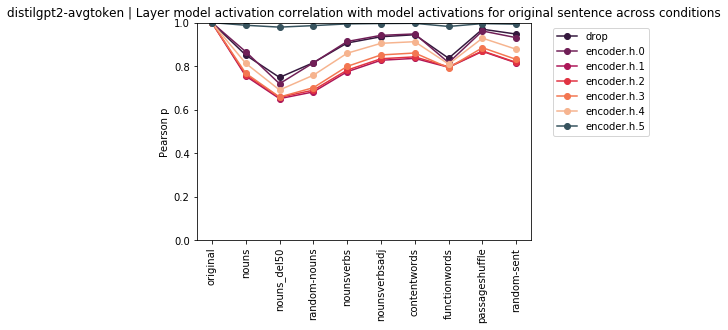

In [22]:
distilgpt2_avg_layers, distilgpt2_avg_conditions, distilgpt2_avg_corr_dict = get_correlations_df_dict("distilgpt2-avgtoken",categories_dict, scr_perturb="perturb")
plot_correlations_lineplot("distilgpt2-avgtoken", distilgpt2_avg_layers, distilgpt2_avg_conditions, distilgpt2_avg_corr_dict,scr_perturb="perturb")

# Loop over models

In [23]:
import math
from matplotlib.gridspec import GridSpec

def get_corr_lineplots_loop(model_list, scr_perturb=None):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    #line_colors = sns.color_palette("rocket") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]] + sns.color_palette("GnBu_d")
    #line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    #if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
    #    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 5*nrows))
    fig2.suptitle(f'Layer model activation correlation with model activations for unperturbed sentence across conditions | {scr_perturb}', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                model_identifier = model_list[model_counter]
                line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
                if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
                    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
                layers, conditions, correlations_df_dict = get_correlations_df_dict(model_identifier,categories_dict, scr_perturb="perturb")
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                counter = 0
                for key,value in correlations_df_dict.items():
                    f2_ax[-1].plot(conditions,value, '-o',color=line_colors[counter])
                    counter += 1
                if len(model_identifier.split("-")) == 1:
                    model_identifier = model_identifier + "-lasttoken"
                f2_ax[-1].set_title(f'{model_identifier}',fontsize=18)
                f2_ax[-1].yaxis.set_label_text('Pearson p')
                #shorten names for legend
                if model_identifier == 'lm_1b':
                    layers = [layer.split('/')[1] for layer in layers]
                if 'albert' in model_identifier:
                    layers = [re.sub('.albert_layer_groups.','.h.', layer) for layer in layers]
                if model_identifier == 'bert-large-uncased-whole-word-masking':
                    layers = ['.'.join(layer.split('.')[:-1]) if '.' in layer else layer for layer in layers]
                f2_ax[-1].legend(layers, bbox_to_anchor=(1.05, 1), loc='upper left')
                f2_ax[-1].set_ylim([0, 1])
                plt.xticks(rotation= 90)
                model_counter += 1
    fig2.savefig(f'fig/{date.today()}_activations-layer-comparison_loop_{scr_perturb}.png', bbox_inches='tight', dpi=240)

Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5



Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5



Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9', 'encoder.h.10', 'encoder.h.11']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5



This is the layer I'm looking at:  encoder.h.6



This is the layer I'm looking at:  encoder.h.7



This is the layer I'm looking at:  encoder.h.8



This is the layer I'm looking at:  encoder.h.9



This is the layer I'm looking at:  encoder.h.10



This is the layer I'm looking at:  encoder.h.11



Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.10', 'encoder.h.11', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.10



This is the layer I'm looking at:  encoder.h.11



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5



This is the layer I'm looking at:  encoder.h.6



This is the layer I'm looking at:  encoder.h.7



This is the layer I'm looking at:  encoder.h.8



This is the layer I'm looking at:  encoder.h.9


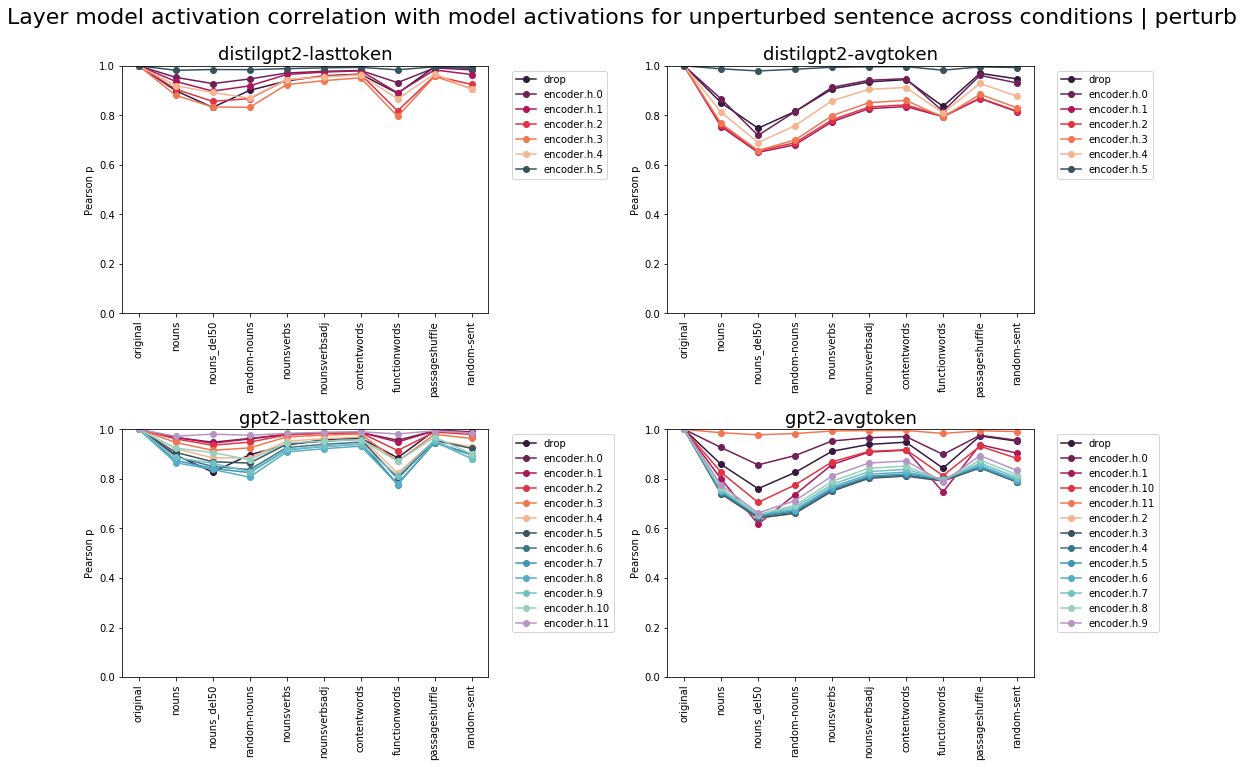

In [24]:
get_corr_lineplots_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-avgtoken"], scr_perturb="perturb")

Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5



Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5



Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9', 'encoder.h.10', 'encoder.h.11']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5



This is the layer I'm looking at:  encoder.h.6



This is the layer I'm looking at:  encoder.h.7



This is the layer I'm looking at:  encoder.h.8



This is the layer I'm looking at:  encoder.h.9



This is the layer I'm looking at:  encoder.h.10



This is the layer I'm looking at:  encoder.h.11



Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.10', 'encoder.h.11', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9']
This is the layer I'm looking at:  drop



This is the layer I'm looking at:  encoder.h.0



This is the layer I'm looking at:  encoder.h.1



This is the layer I'm looking at:  encoder.h.10



This is the layer I'm looking at:  encoder.h.11



This is the layer I'm looking at:  encoder.h.2



This is the layer I'm looking at:  encoder.h.3



This is the layer I'm looking at:  encoder.h.4



This is the layer I'm looking at:  encoder.h.5



This is the layer I'm looking at:  encoder.h.6



This is the layer I'm looking at:  encoder.h.7



This is the layer I'm looking at:  encoder.h.8



This is the layer I'm looking at:  encoder.h.9


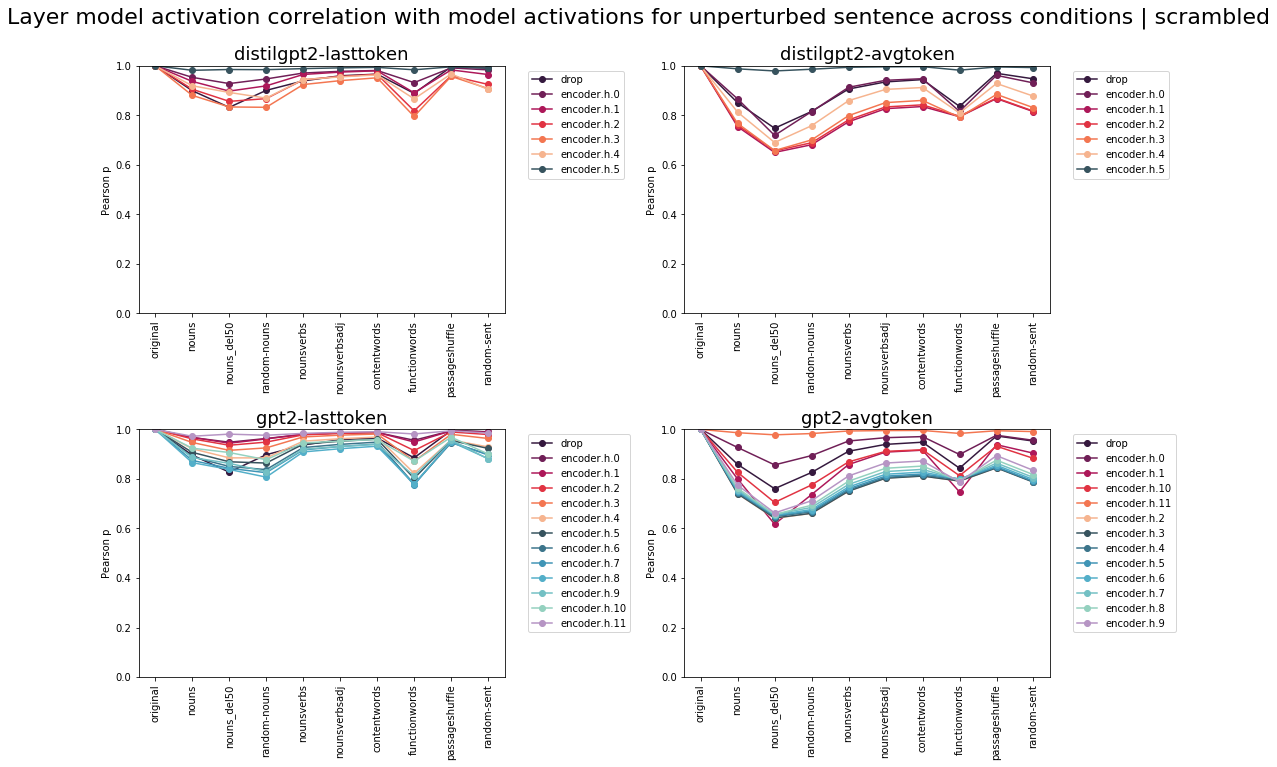

In [25]:
get_corr_lineplots_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-avgtoken"], scr_perturb="scrambled")